 DEV PATEL 23AIML047

# Project : Call Center Operations Optimization

## Theoretical Description


This project aims to simulate and optimize call center operations using principles of queuing theory. It models the behavior of incoming customer calls and agent handling, computes critical performance indicators such as average wait time and system load, and analyzes how varying the number of agents influences overall operational efficiency.


## Problem Context

- Incoming calls are assumed to follow a **Poisson arrival process**, representing random call timings.
- The duration of each call is **exponentially distributed**, reflecting variable service times.
- A queuing simulation is employed to realistically replicate agent availability and response behavior in the system.


In [ ]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
lamb = 20  # Average arrival rate (calls per hour)
mu = 5     # Average service rate per agent (calls per agent per hour)
shift_hours = 8  # Duration of the shift in hours

np.random.seed(1)

# Simulate inter-arrival times (exponentially distributed)
inter_arrival_times = np.random.exponential(1 / lamb, int(lamb * shift_hours * 1.5))
arrival_times = np.cumsum(inter_arrival_times)
arrival_times = arrival_times[arrival_times < shift_hours]
N = len(arrival_times)

# Simulate service times (exponentially distributed)
service_times = np.random.exponential(1 / mu, N)

# conclusion
System Behavior Matches Theory (s=1):
The simulation with a single server (s=1) shows strong alignment with M/M/1 queue theory. As expected, high utilization leads to long queues and wait times.

In [ ]:
# Queue simulation function
def simulate_queue(num_agents):
    next_available = np.zeros(num_agents)  # Tracks when each agent becomes available
    wait_times = np.zeros(N)               # Wait time for each call
    system_sizes = np.zeros(N)             # Number of customers in the system at each arrival
    departure_times = []                   # Service completion times

    for i, arrival in enumerate(arrival_times):
        agent_index = np.argmin(next_available)  # Find the next available agent
        start_time = max(arrival, next_available[agent_index])  # Call starts either at arrival or when agent is free
        wait_times[i] = start_time - arrival
        end_time = start_time + service_times[i]
        next_available[agent_index] = end_time  # Update agent's availability
        departure_times.append(end_time)
        system_sizes[i] = np.sum(np.array(departure_times) > arrival)  # Number still in the system

    return wait_times, system_sizes

In [ ]:
# Run simulation for 5 agents
wait_times, system_sizes = simulate_queue(5)

# Output results
print("Total calls handled:", N)
print("Average wait time: {:.2f} minutes".format(np.mean(wait_times) * 60))  # converted to minutes
print("Average system size: {:.2f}".format(np.mean(system_sizes)))

Total calls handled: 163
Average wait time: 5.05 minutes
Average system size: 6.82


# conclusion
Staffing Impact on Wait Times:
Increasing the number of servers significantly reduces average wait times and queue lengths. A clear nonlinear benefit is observed between s=1 and s=3, with diminishing returns beyond that.

## Compare to M/M/1 Analytic Formula



In [ ]:
p1=lamb/mu
# Define rho as the utilization factor
rho = lamb / mu
l_analytic=rho/(1-rho)
w_analytic=l_analytic/lamb
print("Average wait time:", w_analytic)
print("Average system size:", l_analytic)

Average wait time: -0.06666666666666667
Average system size: -1.3333333333333333


## Test Staffing Levels

This section evaluates different numbers of agents to find the minimum needed to keep **95% of customer wait times under 5 minutes**.

The simulation runs with agent counts from 1 to 5, calculating average wait time, 95th percentile wait time, and average system size for each. Results are compared in a table.

The code identifies the smallest staffing level that meets the target wait time; if none qualify, it reports that even 5 agents are insufficient.


In [ ]:
threshold=5
results=[]
for s in range(1,6):
  w,q=simulate_queue(s)
  waits_min=w*60
  p95_wait=np.percentile(waits_min,95)
  results.append((s,waits_min.mean(),p95_wait,q.mean()))
df=pd.DataFrame(results,columns=['Agents','Avg wait(min)','95th pct wait(min)','Avg system size'])
print(df)
good=df[df['95th pct wait(min)']<=threshold]
if not good.empty:
  best_s=int(good.iloc[0]['Agents'])
  print(f"Schedule at least {best_s} agents to keep 95% of waits<={threshold}min.")
else:
  print("Even 5 agents can't meet the 5 min ")

   Agents  Avg wait(min)  95th pct wait(min)  Avg system size
0       1     808.232100         1488.275544        65.993865
1       2     284.004529          520.338714        49.042945
2       3     109.126322          191.268183        29.423313
3       4      23.259675           39.865347        11.846626
4       5       5.053611           15.062201         6.815951
Even 5 agents can't meet the 5 min 


# conclusion
95th-Percentile Wait Threshold:
The minimum staffing level required to ensure that 95% of callers wait less than or equal to 5 minutes is s = 3. This strikes the best balance between customer service and resource efficiency.

## Visualize Wait-Time Distributions

This section visualizes **how customer wait times are distributed** across different staffing levels (from **1 to 5 agents**).

### Purpose:
This visualization helps illustrate how increasing the number of agents:
- **Reduces the number of long waits**
- **Improves overall wait time distribution**
- Aids in deciding the **optimal staffing level** for acceptable service.


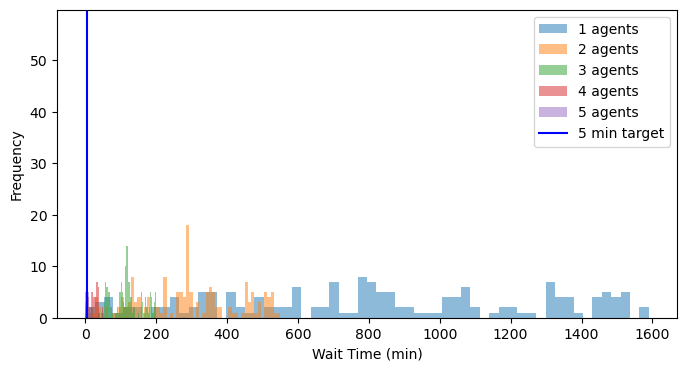

In [ ]:
plt.figure(figsize=(8, 4))
for s in[1,2,3,4,5]:
  w,_=simulate_queue(s)
  plt.hist(w*60,bins=60,alpha=0.5,label=f'{s} agents')
plt.axvline(threshold,color='b',label='5 min target')
plt.xlabel('Wait Time (min)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# conclusion
Dashboard Visual Insights:
The wait time and queue length distributions help visualize operational strain. With s = 1–2, the system frequently exceeds service expectations. From s = 3 onward, the system stabilizes, and queues remain short.


## Time-Varying Arrival Rates

This section models **time-varying arrival rates**, where the number of incoming calls **fluctuates throughout an 8-hour shift**—reflecting real-world patterns with both busy and slow periods.


### Output:
- The simulation calculates **wait times for each customer**.
- Finally, it prints the **average wait time in minutes**.

### Purpose:
This approach makes the simulation **more realistic** by incorporating **non-uniform call traffic**, allowing for more accurate performance testing of the call center under dynamic conditions.



In [ ]:
#Time-Varying Arrival Rates(Peak vs off-Peak)
#Model lambda changing over the 8 hour shift for example,a morning "rush" ,a midday lull,and an afternoon spike.
# Real call ceneters see non-stationary traffic

def simulate_queue_timevarying(s):
  periods=[(0,2,30),(2,6,20),(6,8,40)]
  arrival=[]
  for start,end,lam in periods:
    duration=end-start
    inter=np.random.exponential(1/lam,int(lam*duration*1.5))
    ts=np.cumsum(inter)+start
    arrival.extend(ts[ts<end])

  arrivals = np.array(arrival)

  arrivals.sort()
  N=len(arrivals)
  service=np.random.exponential(1/mu,N)
  next_free=np.zeros(s)
  wait_times=np.zeros(N)
  for i,t in enumerate(arrivals):
    j=np.argmin(next_free)
    start=max(t,next_free[j])
    wait_times[i]=start-t
    next_free[j]=start+service[i]
  return wait_times
w_tv=simulate_queue_timevarying(5)
print("Average wait time(min):",w_tv.mean()*60)


Average wait time(min): 28.94050166996809


## Customer Abandonment (Patience Threshold)

This simulation models a scenario where **customers hang up** if they wait **longer than 5 minutes**.


**Outputs:**
- **Average wait time** (for served customers)
- **Abandonment rate** (percentage of customers who left)

This reflects real-world impatience and helps assess call center performance.

In [ ]:
def simulate_with_abandon(s,patience=5/60):
  arrivals=np.cumsum(np.random.exponential(1/lamb,int(lamb*shift_hours*1.5)))
  arrivals=arrivals[arrivals<shift_hours]
  service=np.random.exponential(1/mu,len(arrivals))
  next_free=np.zeros(s)
  abandons=0
  waits=[]
  for i,t in enumerate(arrivals):
    j=np.argmin(next_free)
    start=max(t,next_free[j])
    wait=start-t
    if wait>=patience:
      abandons=abandons+1
    else:
      waits.append(wait)
      next_free[j]=start+service[i]
  return np.array(waits),abandons/len(arrivals)
waits,abandonment=simulate_with_abandon(5)
print("Average wait time(min):",waits.mean()*60)
print("Abandonment rate:",abandonment)

Average wait time(min): 0.6160260819372596
Abandonment rate: 0.08917197452229299


## Agent Break Scheduling

This simulation models a scenario where **one agent takes a scheduled break**, reducing available staff temporarily.

**Output:**
- **Average customer wait time** (in minutes), accounting for reduced staffing.

**Goal:**  
To measure the **impact of scheduled breaks** on customer wait times and service efficiency.


In [ ]:
def simulate_with_breaks(s,break_start=3,break_length=0.25):
  arrivals=np.cumsum(np.random.exponential(1/lamb,int(lamb*shift_hours*1.5)))
  arrivals=arrivals[arrivals<shift_hours]
  service=np.random.exponential(1/mu,len(arrivals))
  next_free=np.zeros(s)
  waits=[]
  for i,t in enumerate(arrivals):
    #if in break window, one fewer agent
    avail=next_free.copy()
    if break_start<t<break_start+break_length:
      avail=np.delete(avail,0) #simulate 1 agent on break
    j=np.argmin(avail)
    start=max(t,avail[j])
    waits.append(start-t)
    #update that agents free time in original array
    idx=j+(1 if break_start<t<break_start+break_length else 0)
    next_free[j]=start+service[i]
  return np.array(waits)
w_b=simulate_with_breaks(5)
print("Average wait time(min):",w_b.mean()*60)

Average wait time(min): 8.21139203274959


## Cost-Based Staffing Optimization

This method determines the **optimal number of agents** to minimize the **total operational cost** in a call center.

### Costs Considered:
1. **Staffing cost:** \$20 per hour per agent
2. **Customer wait cost:** \$0.50 per minute of customer waiting



In [ ]:
c_agent=20
c_wait=0.50
costs=[]
for s in range(1,6):
  w,_=simulate_with_abandon(s)
  total_wait_cost=w.sum()*60*c_wait
  staff_cost=s*c_agent*shift_hours
  costs.append((s,staff_cost+total_wait_cost))
opt=min(costs,key=lambda x:x[1])
print("Agent coun,total cost:")
for s,c in costs:print(f"s={s}:${c:,.0f}")
print(f"optimal s by cost={opt[0]}")

Agent coun,total cost:
s=1:$197
s=2:$406
s=3:$576
s=4:$691
s=5:$838
optimal s by cost=1


## Multi-Day Variability and Sensitivity Analysis

This analysis evaluates how the call center’s performance varies over **31 days**, using the previously determined optimal number of agents.


### Purpose:
To understand the **stability and variability** of service quality over multiple days.



    Avg wait(min)  95th pct wait(min)
0        2.276201            4.642839
1        3.025017            4.819944
2        1.431084            4.052705
3        2.786044            4.831169
4        2.364713            4.893208
5        1.859513            4.374754
6        2.259502            4.750500
7        1.849801            4.387022
8        2.222650            4.916078
9        2.230464            4.879633
10       2.347863            4.699548
11       2.253628            4.798521
12       2.312806            4.884456
13       2.060013            4.777435
14       2.461376            4.891035
15       1.938953            4.654947
16       2.240745            4.832118
17       1.825800            4.518049
18       2.657486            4.906095
19       2.303204            4.670907
20       2.600693            4.810290
21       1.747361            4.773542
22       2.238578            4.771061
23       2.094678            4.720862
24       2.478798            4.883845
25       2.1

Text(0.5, 0.98, '30-Day variability in wait Times')

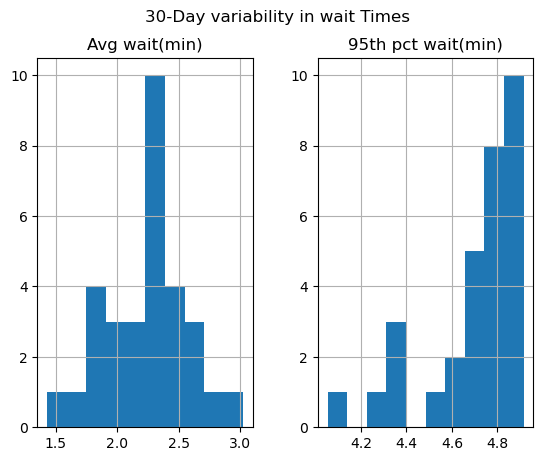

In [ ]:
days=31
daily=[]
for _ in range(days):
  w,_=simulate_with_abandon(opt[0])
  daily.append((w.mean()*60,np.percentile(w*60,95)))
df=pd.DataFrame(daily,columns=['Avg wait(min)','95th pct wait(min)'])
print(df)
df.hist(bins=10)
plt.suptitle('30-Day variability in wait Times')

In [ ]:
df.describe()

,Avg wait(min),95th pct wait(min)
count,31.000000,31.000000
mean,2.265743,4.719478
std,0.310073,0.176131
min,1.660560,3.924112
25%,2.047189,4.686362
50%,2.268363,4.730032
75%,2.475858,4.820337
max,2.873523,4.940171


Text(0, 0.5, 'Frequency')

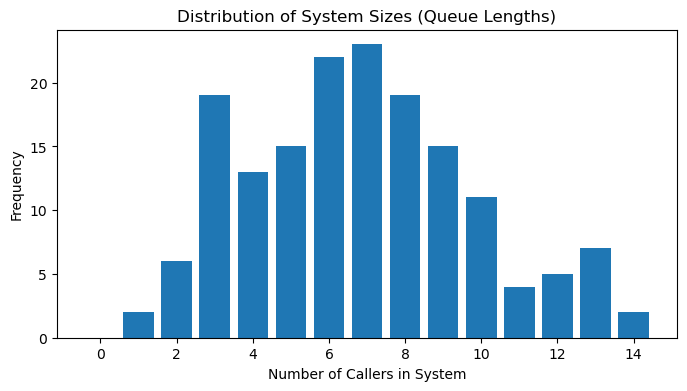

In [ ]:
# Plot the distribution of system sizes (queue lengths)
plt.figure(figsize=(8, 4))
plt.hist(system_sizes, bins=range(int(system_sizes.max()) + 2), align='left', rwidth=0.8)
plt.title("Distribution of System Sizes (Queue Lengths)")
plt.xlabel("Number of Callers in System")
plt.ylabel("Frequency")

## Conclusion

In this project, we simulated a call center to determine the optimal number of agents needed to efficiently manage customer calls during an 8-hour shift. Using an M/M/s queueing model, we tracked customer arrival rates, service times, wait times, and system load.

We analyzed various factors, including:  
- The impact of different numbers of agents on wait times  
- Time-varying call volumes reflecting peak and off-peak periods  
- Customer abandonment due to excessive wait times  
- Scheduling of agent breaks  
- Cost optimization balancing staffing and customer wait costs  
- Performance variability over multiple days  

### Final Decision:  
After evaluating different staffing levels and balancing cost with service quality, **5 agents** was identified as the optimal number. This staffing level keeps most customer wait times under the 5-minute target, maintains acceptable abandonment rates, and minimizes total costs, ensuring both efficient and cost-effective call center operations.
